In [85]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

import matplotlib
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context

sc.set_figure_params(format="png")
import anndata as ad
import seaborn as sns
from PIL import Image
from scipy import ndimage
from skimage import exposure, measure, morphology
from sklearn.cluster import MiniBatchKMeans
import math
import cv2
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [86]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [87]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


In [89]:
adata = ad.read_h5ad('foll.h5ad')

# Expression along minor and major axis

In [90]:
from sklearn.preprocessing import LabelEncoder

def get_variation(adata, markers=None, x_name='Major_Col', y_name='Minor_Col', n=50):
    if markers is None:
        markers = adata.var_names.tolist()
    df_intensity = adata.to_df()[markers]
    df_intensity['X'] = adata.obs[x_name].to_numpy()
    df_intensity['Y'] = adata.obs[y_name].to_numpy()
    
    # Sort and define quantile cut 
    df = df_intensity.sort_values(by=['X'])
    df['X_sort'] = pd.qcut(df["X"], n)
    df['Y_sort'] = pd.qcut(df["Y"], n)

    # Create label for quantile 
    LE = LabelEncoder()
    df['X_sort'] = LE.fit_transform(df['X_sort'])
    df_major = df[markers +['X_sort']]

    df['Y_sort']= LE.fit_transform(df['Y_sort'])
    df_minor = df[markers +['Y_sort']]

    # Heatmap plot
    df_major = df[markers + ['X_sort']]
    df_major_mean = df_major.groupby('X_sort').mean()
    df_major = df[markers + ['Y_sort']]
    df_minor_mean = df_major.groupby('Y_sort').mean()

    return df_major_mean, df_minor_mean 

    

In [91]:
donors = ["TS Donor A", "TS Donor E"]

donors = [
    "LN Donor A",
    "LN Donor E",
]

donors = [
    "INT Donor B",
    "INT Donor E",
]

# donors = ["TS Donor E"]

In [92]:
markers = ['CD21', 'CD4', 'CXCR5', 'CD20', 'CD8', 'PD1', 'Ki67', 'COL1', 'CD3', 'EZH2']

In [93]:
for d in donors:
    adata_donor = adata[adata.obs['Dataset'] == d]
    foll_ids = adata_donor.obs.Foll.unique()
    dfs_major_col = []
    dfs_minor_col = []
    dfs_major_mor = []
    dfs_minor_mor = []
    for foll_id in foll_ids:
        # print(foll_id)
        adata_foll = adata_donor[adata_donor.obs['Foll'] == foll_id]
        if len(adata_foll)<1000:
            continue
        df_major_mean, df_minor_mean = get_variation(adata_foll, markers=markers)
        dfs_major_col.append(df_major_mean)
        dfs_minor_col.append(df_minor_mean)
        
        # fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
        # ax1 = sns.heatmap(df_major_mean.T, ax=ax1, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=False)
        # ax1.set(xlabel='Major axis')
        # ax2 = sns.heatmap(df_minor_mean.T, ax=ax2, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7})
        # ax2.set(xlabel='Minor axis')
        # plt.tight_layout()
        # plt.show()
        
        df_major_mean, df_minor_mean = get_variation(adata_foll, markers=markers, x_name='Major_Mor', y_name='Minor_Mor')
        dfs_major_mor.append(df_major_mean)
        dfs_minor_mor.append(df_minor_mean)
        
        # fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,7))
        # ax1 = sns.heatmap(df_major_mean.T, ax=ax1, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=False)
        # ax1.set(xlabel='Major axis')
        # ax2 = sns.heatmap(df_minor_mean.T, ax=ax2, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7})
        # ax2.set(xlabel='Minor axis')
        # plt.tight_layout()
        # plt.show()


In [94]:
df_major = pd.concat(dfs_major_col)
by_row_index = df_major.groupby(df_major.index)
df_means_major = by_row_index.mean()

df_minor = pd.concat(dfs_minor_col)
by_row_index = df_minor.groupby(df_major.index)
df_means_minor = by_row_index.mean()

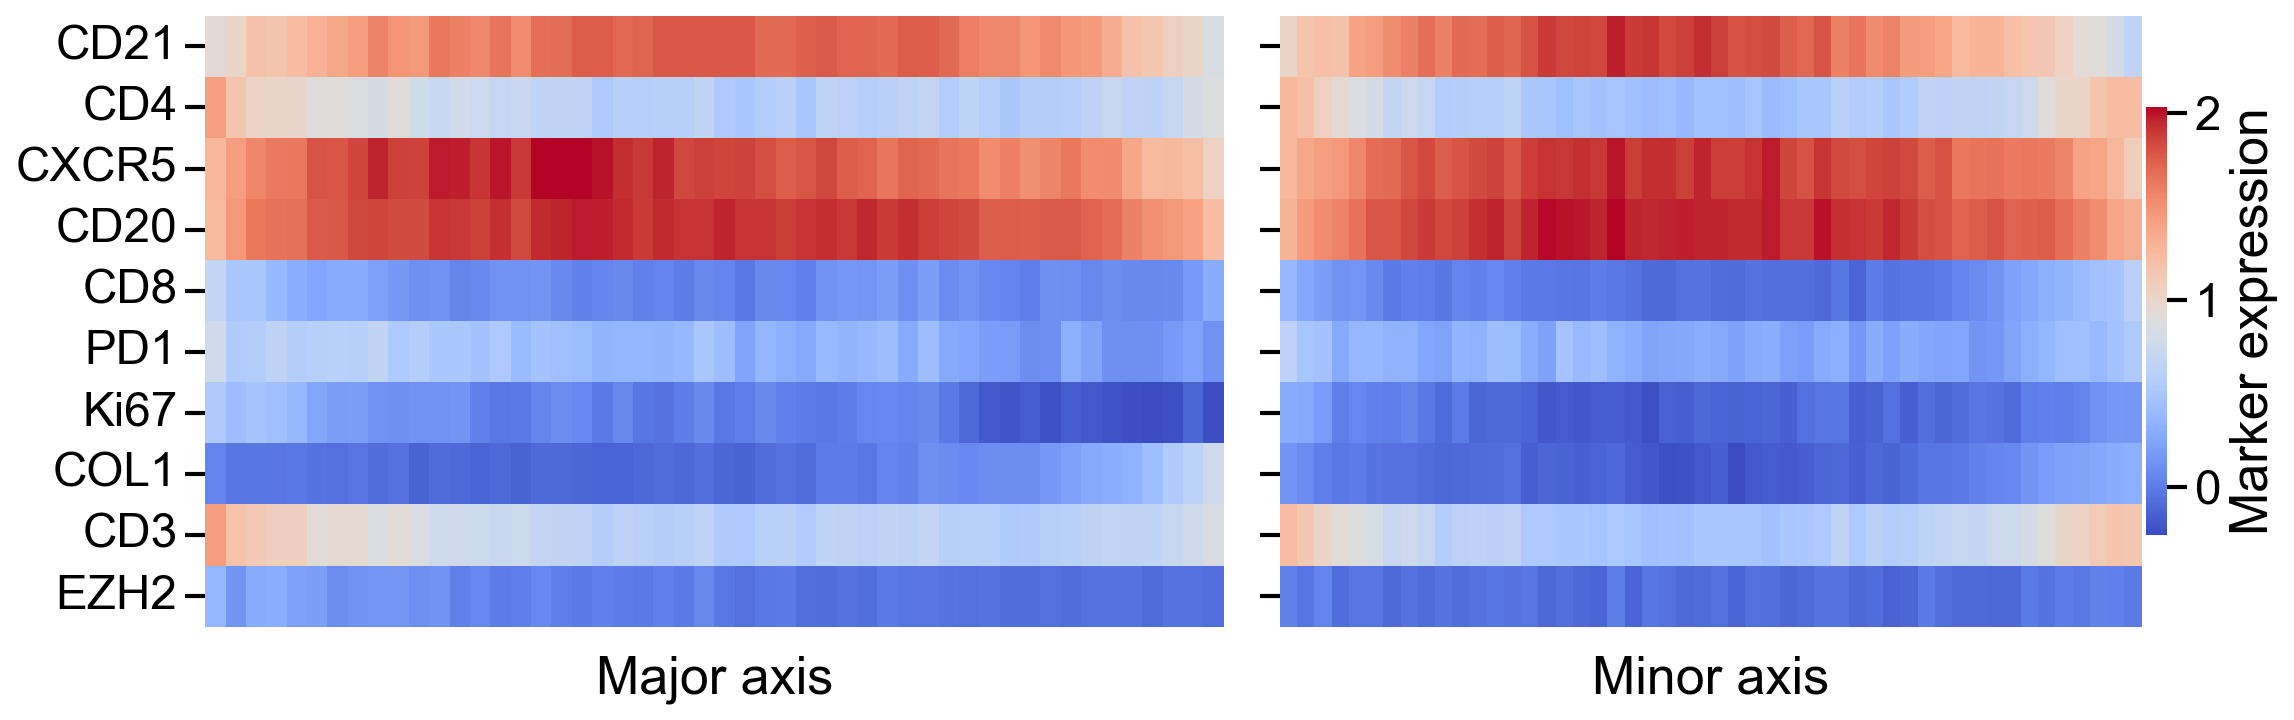

In [95]:
with sns.plotting_context('talk', font_scale=1.3):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    ax1 = sns.heatmap(df_means_major.T, ax=ax1, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=False)
    ax1.set(xlabel='Major axis')
    ax2 = sns.heatmap(df_means_minor.T, ax=ax2, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7})
    ax2.set(xlabel='Minor axis')
    plt.tight_layout()
    plt.show()


In [96]:
df_major = pd.concat(dfs_major_mor)
by_row_index = df_major.groupby(df_major.index)
df_means_major = by_row_index.mean()

df_minor = pd.concat(dfs_minor_mor)
by_row_index = df_minor.groupby(df_major.index)
df_means_minor = by_row_index.mean()

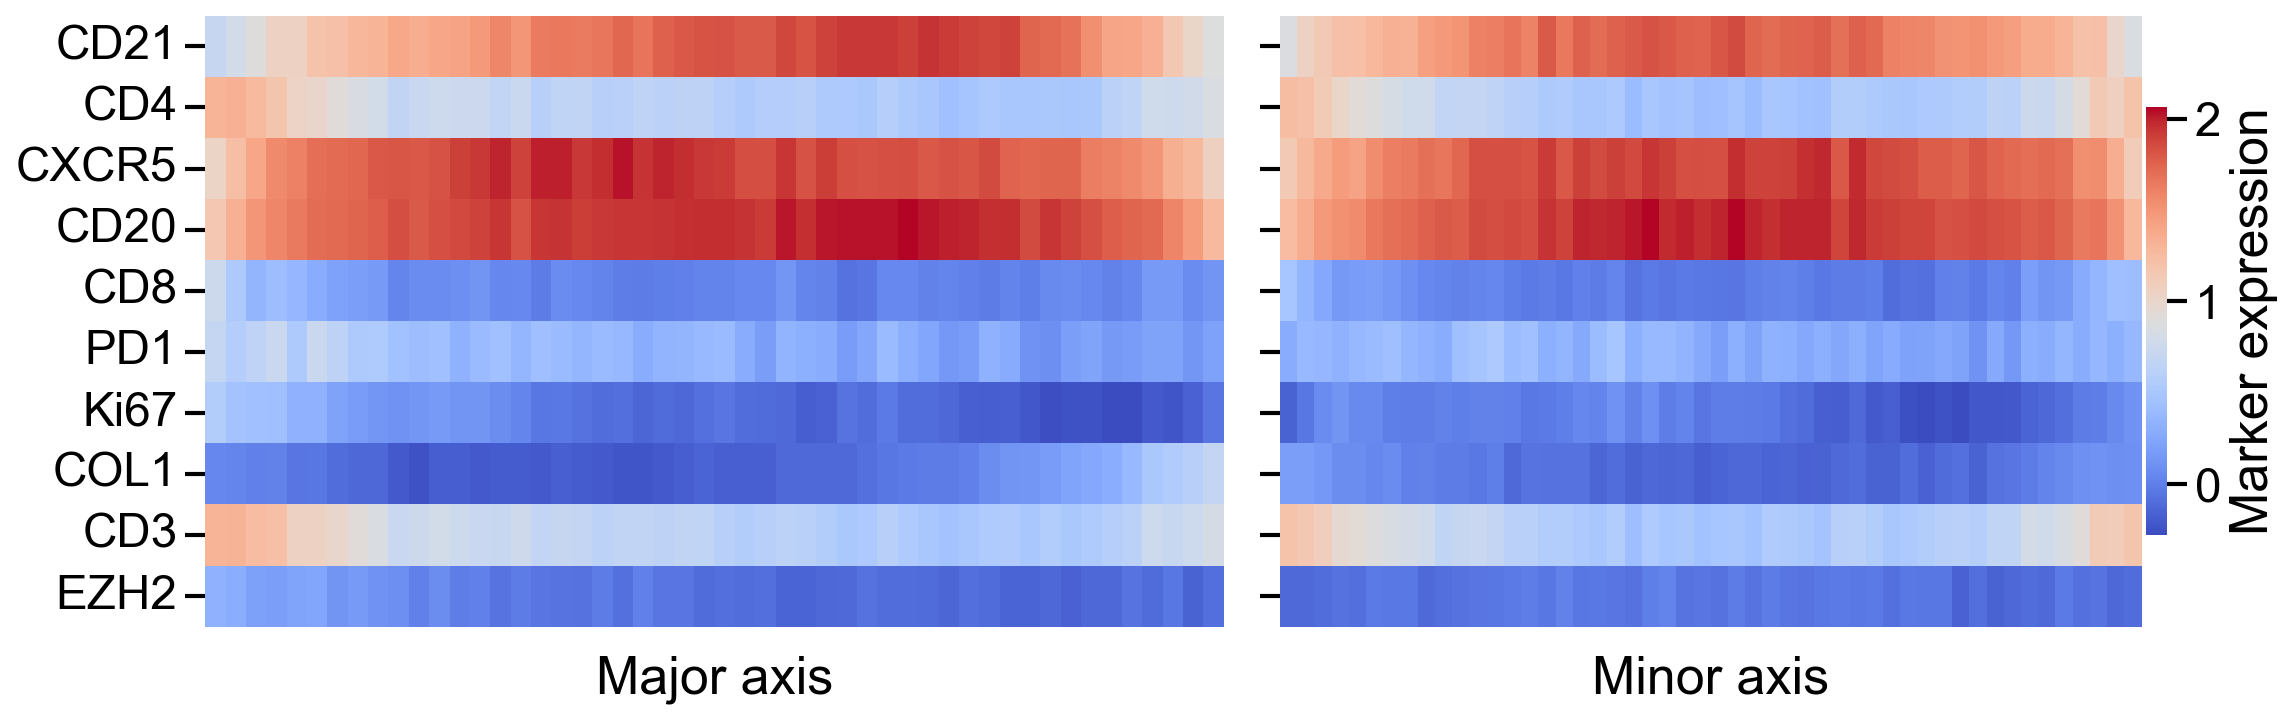

In [97]:
with sns.plotting_context('talk', font_scale=1.3):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    ax1 = sns.heatmap(df_means_major.T, ax=ax1, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=False)
    ax1.set(xlabel='Major axis')
    ax2 = sns.heatmap(df_means_minor.T, ax=ax2, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7})
    ax2.set(xlabel='Minor axis')
    plt.tight_layout()
    plt.show()


# Cell type along axis

In [98]:
from sklearn.preprocessing import LabelEncoder

def get_variation_cell_type(adata, phenotype='cluster', x_name='Major_Col', y_name='Minor_Col', n=20):

    df_intensity = sc.get.obs_df(adata, keys=[phenotype])
    df_intensity['X'] = adata.obs[x_name].to_numpy()
    df_intensity['Y'] = adata.obs[y_name].to_numpy()
    
    # Sort and define quantile cut 
    df = df_intensity.sort_values(by=['X'])
    df['X_sort'] = pd.qcut(df["X"], n)
    df['Y_sort'] = pd.qcut(df["Y"], n)

    # Create label for quantile 
    LE = LabelEncoder()
    df['X_sort'] = LE.fit_transform(df['X_sort'])
    df_major = df[[phenotype] +['X_sort']]

    df['Y_sort']= LE.fit_transform(df['Y_sort'])
    df_minor = df[[phenotype] +['Y_sort']]

    # Heatmap plot
    df_major = df[[phenotype] + ['X_sort']]
    df_major_mean = df_major.groupby('X_sort', as_index=False).value_counts()
    df_major = df[[phenotype] + ['Y_sort']]
    df_minor_mean = df_major.groupby('Y_sort', as_index=False).value_counts()

    df_major_pivot = df_major_mean.pivot(index='X_sort', columns='cluster', values='count')
    
    df_minor_pivot = df_minor_mean.pivot(index='Y_sort', columns='cluster', values='count')
    
    return df_major_pivot, df_minor_pivot 

    

In [99]:
adata 

AnnData object with n_obs × n_vars = 268218 × 17
    obs: 'ROI', 'Cell', 'Dataset', 'leiden', 'Phenotype_r1', 'Phenotype_r1_n', 'Phenotype', 'Major_Col', 'Minor_Col', 'Major_Mor', 'Minor_Mor', 'Foll'
    obsm: 'X_scanorama', 'X_tsne', 'spatial'

In [100]:
rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
               'Stroma Vimentin+': 'Stroma'
              }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


In [101]:
for d in donors:
    adata_donor = adata[adata.obs['Dataset'] == d]
    foll_ids = adata_donor.obs.Foll.unique()
    dfs_major_col = []
    dfs_minor_col = []
    dfs_major_mor = []
    dfs_minor_mor = []
    for foll_id in foll_ids:
        # print(foll_id)
        adata_foll = adata_donor[adata_donor.obs['Foll'] == foll_id]
        if len(adata_foll)<1000:
            continue
            
        df_major_pivot, df_minor_pivot = get_variation_cell_type(adata_foll)
        df_major_pivot = df_major_pivot.div(df_major_pivot.sum(axis=1), axis=0)
        df_minor_pivot = df_minor_pivot.div(df_minor_pivot.sum(axis=1), axis=0)
        dfs_major_col.append(df_major_pivot)
        dfs_minor_col.append(df_minor_pivot)
        
        
        df_major_pivot, df_minor_pivot = get_variation_cell_type(adata_foll, x_name='Major_Mor', y_name='Minor_Mor')
        df_major_pivot = df_major_pivot.div(df_major_pivot.sum(axis=1), axis=0)
        df_minor_pivot = df_minor_pivot.div(df_minor_pivot.sum(axis=1), axis=0)
        dfs_major_mor.append(df_major_pivot)
        dfs_minor_mor.append(df_minor_pivot)
        
        # fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
        # ax1 = sns.heatmap(df_major_pivot.T, ax=ax1, cmap='jet', xticklabels=False, yticklabels=True, cbar=False)
        # ax1.set(xlabel='Major axis')
        # ax2 = sns.heatmap(df_minor_pivot.T, ax=ax2, cmap='jet', xticklabels=False, yticklabels=True, cbar_kws={"label": "Count", "pad": 0.004, "shrink": 0.7})
        # ax2.set(xlabel='Minor axis')
        # ax2.set(ylabel=None)
        # plt.tight_layout()
        # plt.show()

In [102]:
df_major = pd.concat(dfs_major_col)
by_row_index = df_major.groupby(df_major.index)
df_means_major = by_row_index.mean()

df_minor = pd.concat(dfs_minor_col)
by_row_index = df_minor.groupby(df_major.index)
df_means_minor = by_row_index.mean()

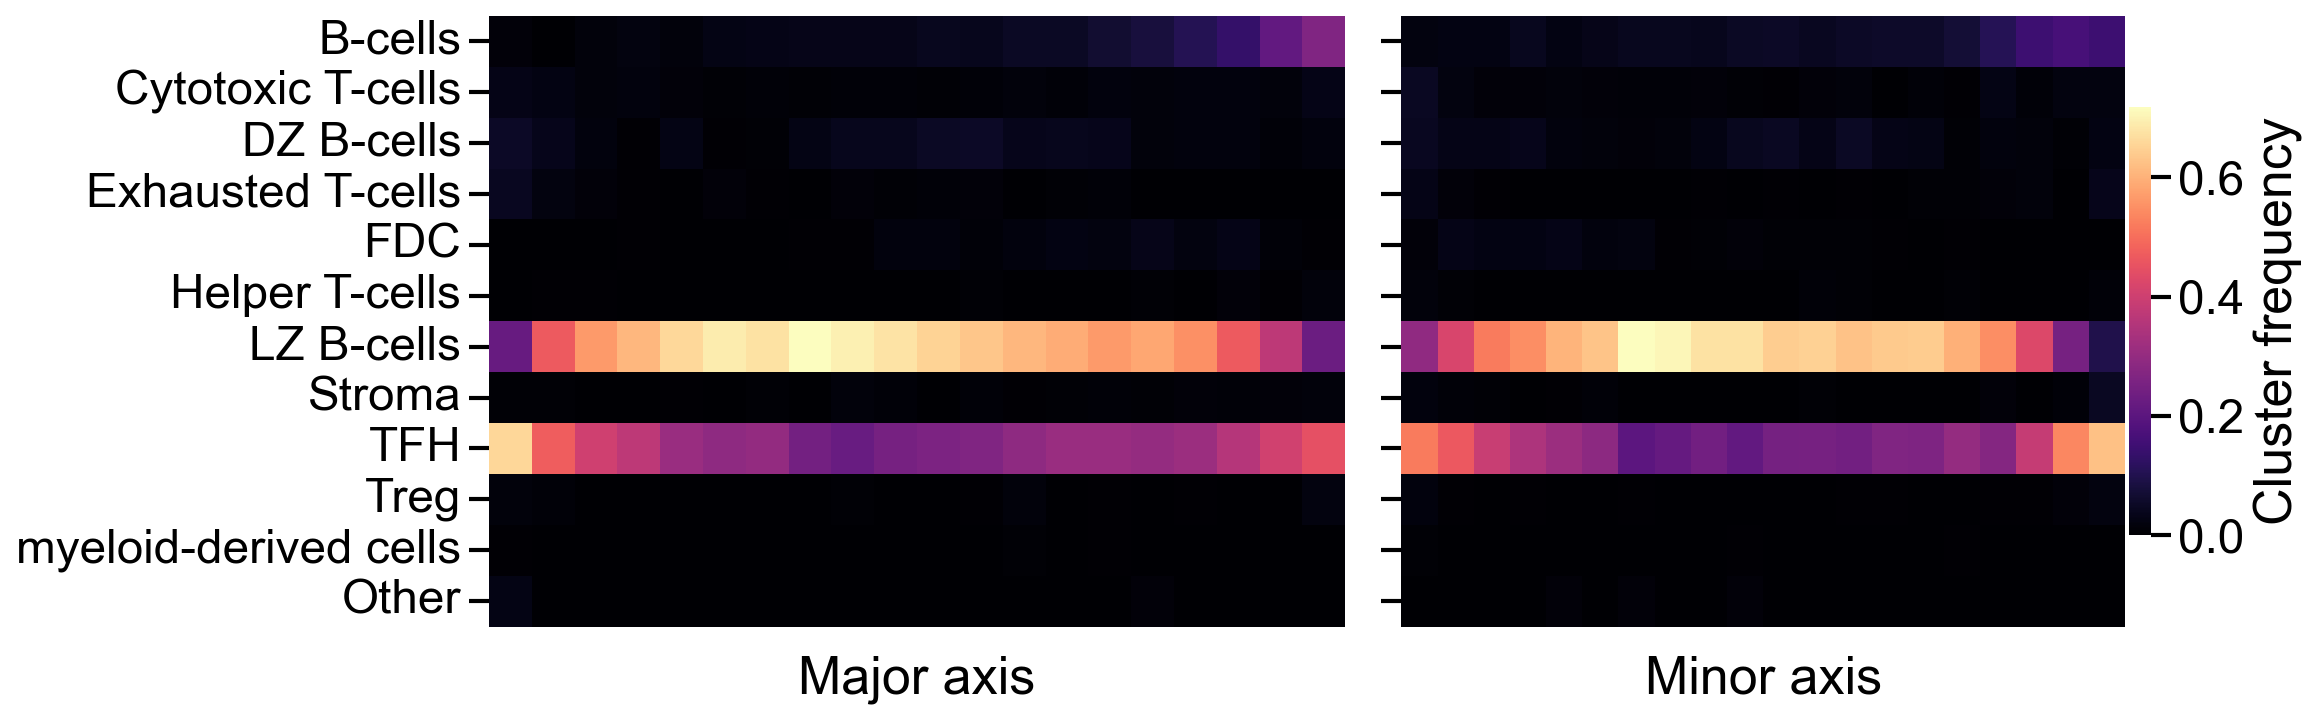

In [103]:
with sns.plotting_context('talk', font_scale=1.3):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    ax1 = sns.heatmap(df_means_major.T, ax=ax1, cmap="magma", xticklabels=False, 
                      yticklabels=True, cbar=False)
    ax1.set(xlabel='Major axis', ylabel=None)
    ax2 = sns.heatmap(df_means_minor.T, ax=ax2, cmap="magma", xticklabels=False, 
                      yticklabels=True, cbar_kws={"label": "Cluster frequency", "pad": 0.005, "shrink": 0.7})
    ax2.set(xlabel='Minor axis', ylabel=None)
    plt.tight_layout()
    plt.show()


In [104]:
df_major = pd.concat(dfs_major_mor)
by_row_index = df_major.groupby(df_major.index)
df_means_major = by_row_index.mean()

df_minor = pd.concat(dfs_minor_mor)

by_row_index = df_minor.groupby(df_major.index)
df_means_minor = by_row_index.mean()

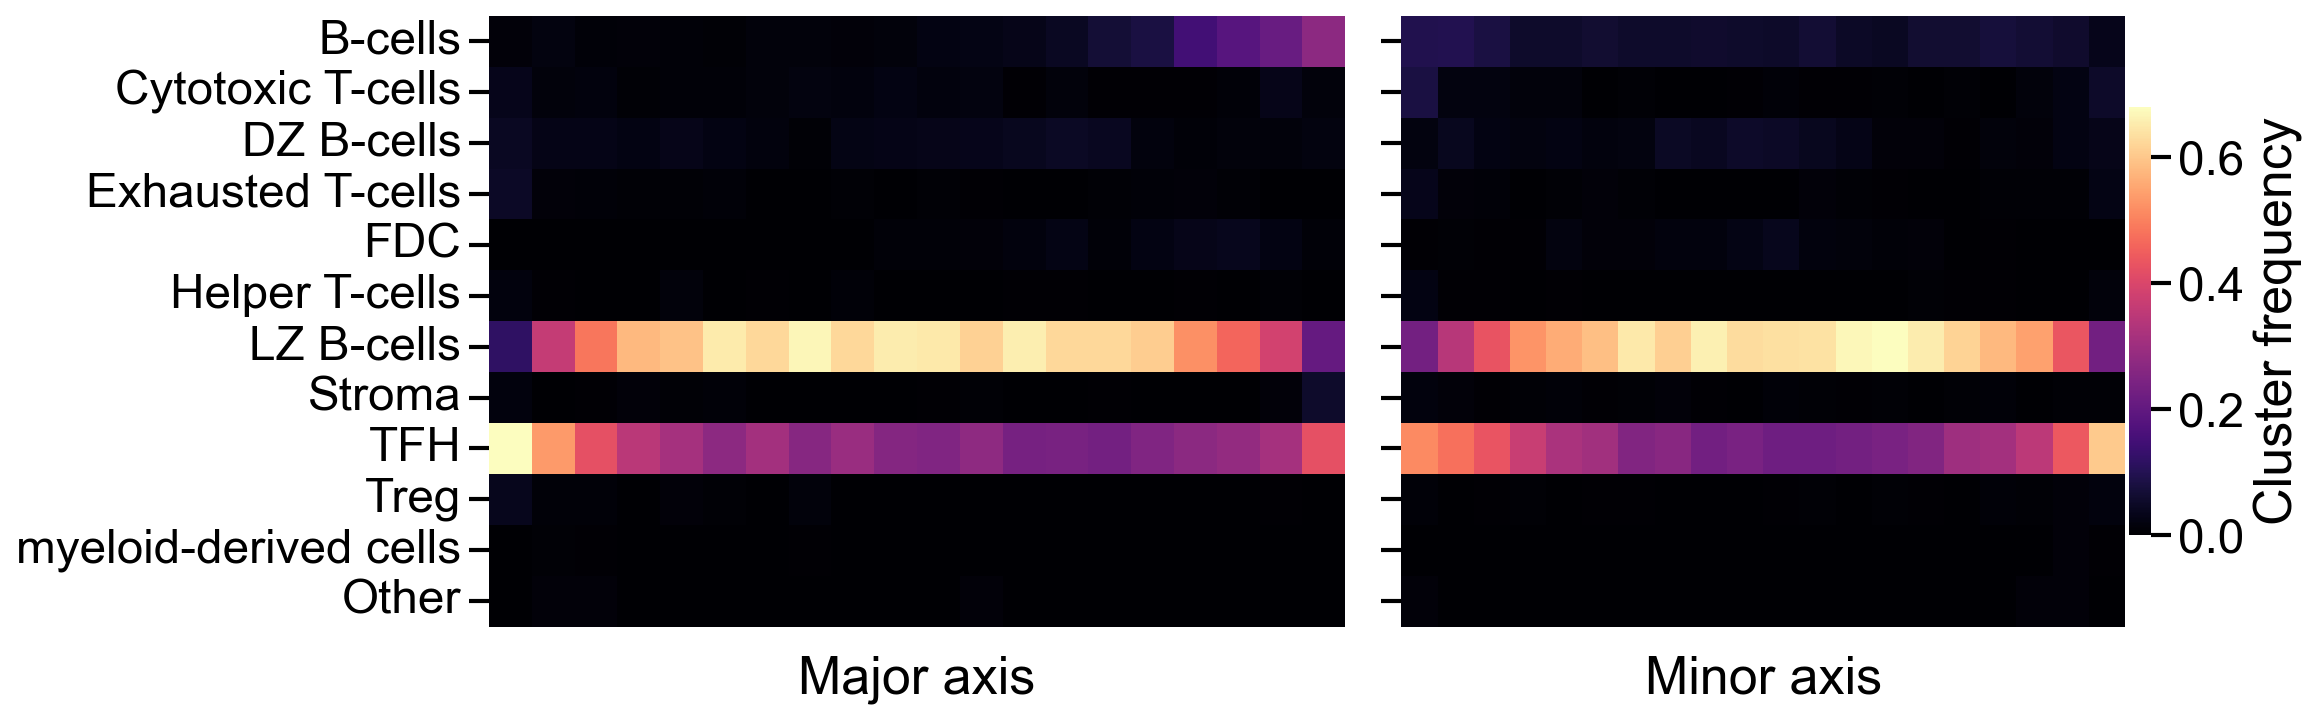

In [105]:
with sns.plotting_context('talk', font_scale=1.3):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    ax1 = sns.heatmap(df_means_major.T, ax=ax1, cmap="magma", xticklabels=False, 
                      yticklabels=True, cbar=False)
    ax1.set(xlabel='Major axis', ylabel=None)
    ax2 = sns.heatmap(df_means_minor.T, ax=ax2, cmap="magma", xticklabels=False, 
                      yticklabels=True, cbar_kws={"label": "Cluster frequency", "pad": 0.005, "shrink": 0.7})
    ax2.set(xlabel='Minor axis', ylabel=None)
    plt.tight_layout()
    plt.show()
